In [ ]:
import pandas as pd
import re
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
root_folder = "gdrive/MyDrive/emotion_recognition/"
data_path = root_folder + "data_init/"
res_folder = root_folder + 'experiments/'

In [ ]:
df_meta = pd.read_csv(res_folder + 'latest_ok.csv')
df_meta.columns

Index(['Unnamed: 0.7', 'Unnamed: 0.6', 'Unnamed: 0.5', 'Unnamed: 0.4',
       'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0',
       'folder_name', 'audio_file_name', 'emotion', 'speech_duration',
       'language', 'origin_text', 'openai/whisper-tiny_transc',
       'openai/whisper-tiny_wer', 'openai/whisper-base_transc',
       'openai/whisper-base_wer', 'openai/whisper-medium_transc',
       'openai/whisper-medium_wer', 'openai/whisper-large_transc',
       'openai/whisper-large_wer', 'openai/whisper-large-v2_transc',
       'openai/whisper-large-v2_wer', 'openai/whisper-large-v3_transc',
       'openai/whisper-large-v3_wer', 'facebook/wav2vec2-base-960h_transc',
       'facebook/wav2vec2-base-960h_wer',
       'Yehor/wav2vec2-xls-r-300m-uk-with-small-lm_transc',
       'Yehor/wav2vec2-xls-r-300m-uk-with-small-lm_wer',
       'arampacha/whisper-large-uk-2_transc',
       'arampacha/whisper-large-uk-2_wer',
       'robinhad/wav2vec2-xls-r-300m-uk_transc',
       'robinh

In [ ]:
import ast
df_meta['origin_text'] = df_meta['origin_text'].apply(lambda x: ' '.join(ast.literal_eval(x)))

df_meta['conflict'] = 0
df_meta.loc[df_meta['emotion'].isin(['angry', 'disgust']), 'conflict'] = 1

df_meta['conflict_sad'] = 0
df_meta.loc[df_meta['emotion'].isin(['angry', 'disgust', 'sad']), 'conflict_sad'] = 1

# Models

In [ ]:
import torch
from transformers import pipeline


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# create a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

print(device, torch_dtype)

cuda:0 torch.float16


In [ ]:
def get_classifier(model_name="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"):
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  if model_name in ["MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
                        "MoritzLaurer/deberta-v3-base-zeroshot-v1.1-all-33",
                        "MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33"]:
    classifier = pipeline("zero-shot-classification", model=model_name, device=device)
    return classifier

  if model_name in ["lxyuan/distilbert-base-multilingual-cased-sentiments-student"]:
    return pipeline(model=model_name, device=device)

  if model_name in ["siebert/sentiment-roberta-large-english",
                    "cardiffnlp/twitter-roberta-base-sentiment-latest"]:
    return pipeline("sentiment-analysis", model=model_name, device=device)

  if model_name in ["SamLowe/roberta-base-go_emotions"]:
    return pipeline(task="text-classification", model=model_name, top_k=None)


# Evaluation metrics

# Evaluation functions

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [ ]:
import time
import wandb
import numpy as np
from tqdm.auto import tqdm

In [ ]:
tqdm.pandas()

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
res_folder = root_folder + 'experiments/'

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

def evaluate(y_true, y_pred, run, display_cm=True, display_cr=True):
    # print(f"f1-score: {round(f1_score(y_true, y_pred, average='binary'),2)}, accuracy: {round(accuracy_score(y_true, y_pred),2)}")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    if display_cm:
      disp = ConfusionMatrixDisplay(confusion_matrix=cm)
      disp.plot()
      plt.show()

    if display_cr:
      cr = classification_report(y_true, y_pred, target_names=['no_conflict', 'conflict'])
      print(cr)

    if run:
      wandb.sklearn.plot_confusion_matrix(y_true, y_pred, ['no_conflict', 'conflict'])

      cr = classification_report(y_true, y_pred, target_names=['no_conflict', 'conflict'], output_dict=True)
      run.log({"accuracy" : cr['accuracy'],
              "no_conflict_precision" : cr['no_conflict']['precision'],
              "no_conflict_recall" : cr['no_conflict']['recall'],
              "no_conflict_f1-score" : cr['no_conflict']['f1-score'],
              "conflict_precision" : cr['conflict']['precision'],
              "conflict_recall" : cr['conflict']['recall'],
              "conflict_f1-score" : cr['conflict']['f1-score']})

In [ ]:
def predict(transcript_column, classifier, labels, multi_label):
    if labels:
      output = classifier(transcript_column, labels, multi_label=multi_label, generator=generator)
      predict = output['labels'][np.argmax(output['scores'])]
    else:
      output = classifier(transcript_column[:512]) # , generator=generator how to pass random seed???

      #print(output)
      if len(output) > 1:
          output[0] = [x for x in output[0] if not ('neutral' == x.get('label'))]

          predict = max(output[0], key=lambda x:x['score'])['label']
      else:
          predict = output[0]['label']

    return predict

In [ ]:
def output_to_binary(results, conflict_labels):
  binary_res = [1 if value in conflict_labels else 0 for value in results]
  return binary_res

In [ ]:
wandb.finish()

In [ ]:
def eval_class_model(model_name, labels, labels_lang, df, text_column, class_column, conflict_labels=None, log=True, saveTo=None):
  config = {
    "model_name" : model_name,
    "fine-tuned" : False,
    "framework" : "HF pipeline",
    "data" : "init_full_1h",
    "text_origin" : text_column,
    "task" : "zero-shot-classification",
    "labels" : labels,
    "n_lables" : len(labels) if labels else 0,
    "labels_lang" : labels_lang,
    "multi_label" : False,
    "prompt" : "",
    "prompt_lang" : "",
    "device" : device,
    "torch_dtype" : torch_dtype,
  }

  run = None

  if log:
    timestr = time.strftime("%m%d-%H%M")
    run = wandb.init(project="emotion_recognition",
              name=f"e_{timestr}_basic_eval_llm",
              config=config)

  #TODO: it should be possible to pass whole list at once into classifier!!!
  classifier = get_classifier(model_name)
  output = df[text_column].progress_apply(predict, args=(classifier, labels, 0)).values

  binary_output = output_to_binary(output, conflict_labels)

  if saveTo:
    df[saveTo] = binary_output

  evaluate(df[class_column], binary_output, run)
  if log:
    wandb.finish()
  # return binary_output, output

# LLM classifiers

## Zero-shot-classifier

  0%|          | 0/90 [00:00<?, ?it/s]

[[39 12]
 [ 6 33]]


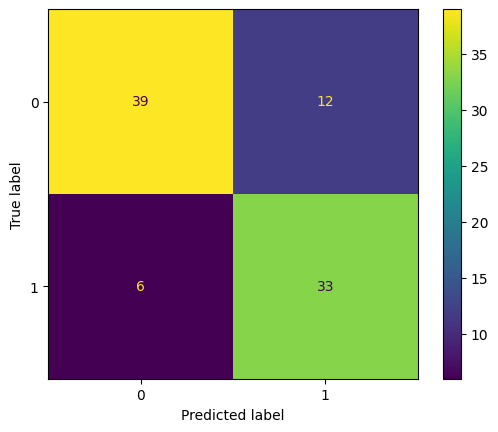

              precision    recall  f1-score   support

 no_conflict       0.87      0.76      0.81        51
    conflict       0.73      0.85      0.79        39

    accuracy                           0.80        90
   macro avg       0.80      0.81      0.80        90
weighted avg       0.81      0.80      0.80        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.8
conflict_f1-score,0.78571
conflict_precision,0.73333
conflict_recall,0.84615


  0%|          | 0/90 [00:00<?, ?it/s]

[[40 11]
 [11 28]]


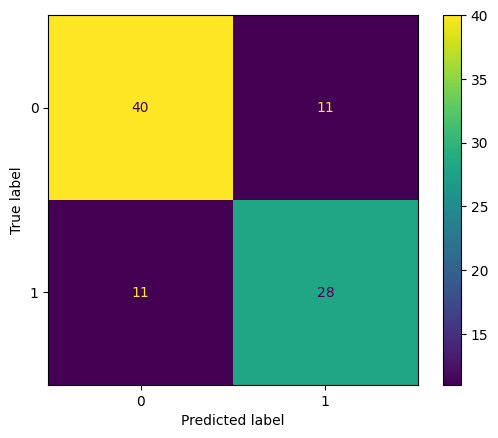

              precision    recall  f1-score   support

 no_conflict       0.78      0.78      0.78        51
    conflict       0.72      0.72      0.72        39

    accuracy                           0.76        90
   macro avg       0.75      0.75      0.75        90
weighted avg       0.76      0.76      0.76        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.75556
conflict_f1-score,0.71795
conflict_precision,0.71795
conflict_recall,0.71795


  0%|          | 0/90 [00:00<?, ?it/s]

[[14 37]
 [ 4 35]]


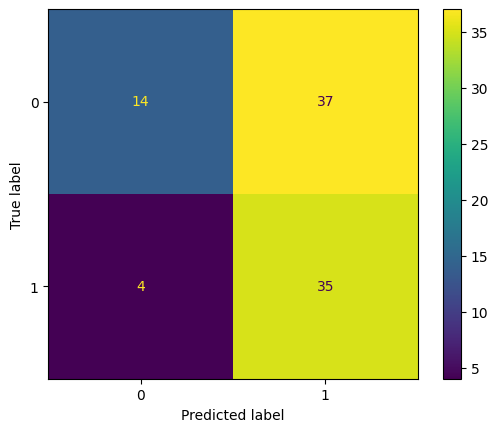

              precision    recall  f1-score   support

 no_conflict       0.78      0.27      0.41        51
    conflict       0.49      0.90      0.63        39

    accuracy                           0.54        90
   macro avg       0.63      0.59      0.52        90
weighted avg       0.65      0.54      0.50        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.54444
conflict_f1-score,0.63063
conflict_precision,0.48611
conflict_recall,0.89744


  0%|          | 0/90 [00:00<?, ?it/s]

[[43  8]
 [25 14]]


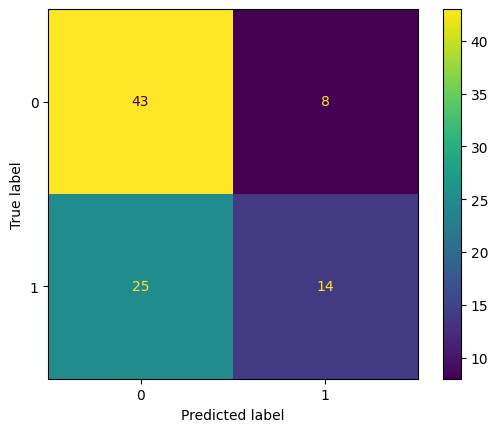

              precision    recall  f1-score   support

 no_conflict       0.63      0.84      0.72        51
    conflict       0.64      0.36      0.46        39

    accuracy                           0.63        90
   macro avg       0.63      0.60      0.59        90
weighted avg       0.63      0.63      0.61        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.63333
conflict_f1-score,0.45902
conflict_precision,0.63636
conflict_recall,0.35897


In [ ]:
labels = [(["positive", "negative"], ['negative']),
          (["positive", "negative", "neutral"], ['negative']),
          (["conflict", "neutral"], ['conflict']),
          (["happy", "angry", "neutral"], ['angry'])]

text_columns = ['openai/whisper-large-v2_translate']
lang="eng"
models = ["MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"]

for text_column in text_columns:
  for text_labels, negative_lables in labels:
    eval_class_model(models[0], text_labels, labels_lang=lang, df=df_meta,
                    text_column=text_column, class_column="conflict_sad",
                    conflict_labels=negative_lables)

  0%|          | 0/90 [00:00<?, ?it/s]

[[44  7]
 [14 25]]


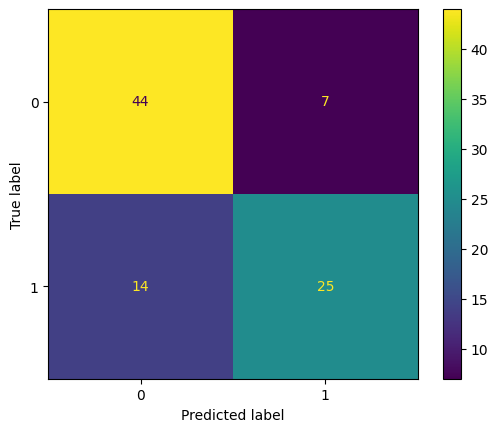

              precision    recall  f1-score   support

 no_conflict       0.76      0.86      0.81        51
    conflict       0.78      0.64      0.70        39

    accuracy                           0.77        90
   macro avg       0.77      0.75      0.76        90
weighted avg       0.77      0.77      0.76        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.76667
conflict_f1-score,0.70423
conflict_precision,0.78125
conflict_recall,0.64103


  0%|          | 0/90 [00:00<?, ?it/s]

[[37 14]
 [ 8 31]]


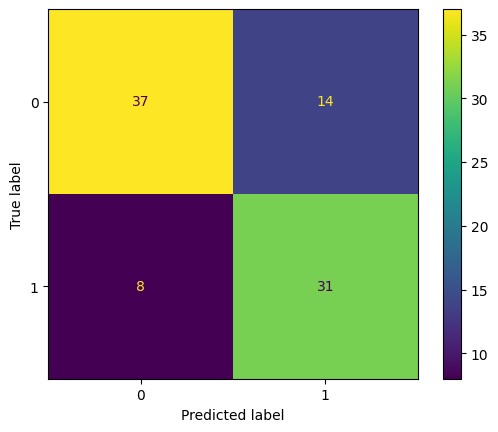

              precision    recall  f1-score   support

 no_conflict       0.82      0.73      0.77        51
    conflict       0.69      0.79      0.74        39

    accuracy                           0.76        90
   macro avg       0.76      0.76      0.75        90
weighted avg       0.76      0.76      0.76        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.75556
conflict_f1-score,0.7381
conflict_precision,0.68889
conflict_recall,0.79487


  0%|          | 0/90 [00:00<?, ?it/s]

[[47  4]
 [15 24]]


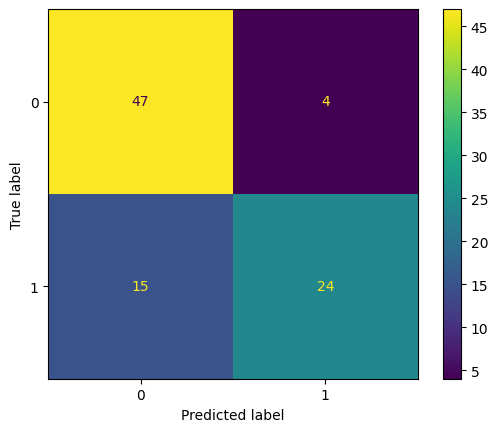

              precision    recall  f1-score   support

 no_conflict       0.76      0.92      0.83        51
    conflict       0.86      0.62      0.72        39

    accuracy                           0.79        90
   macro avg       0.81      0.77      0.77        90
weighted avg       0.80      0.79      0.78        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.78889
conflict_f1-score,0.71642
conflict_precision,0.85714
conflict_recall,0.61538


  0%|          | 0/90 [00:00<?, ?it/s]

[[51  0]
 [28 11]]


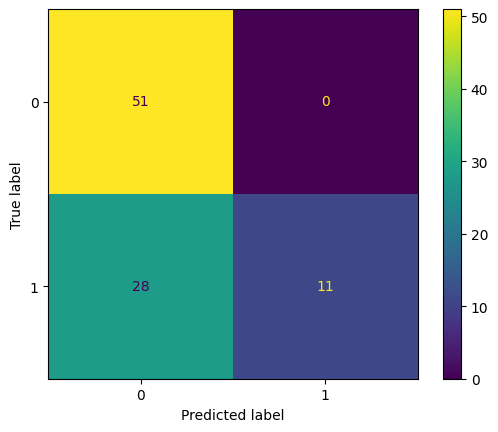

              precision    recall  f1-score   support

 no_conflict       0.65      1.00      0.78        51
    conflict       1.00      0.28      0.44        39

    accuracy                           0.69        90
   macro avg       0.82      0.64      0.61        90
weighted avg       0.80      0.69      0.64        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.68889
conflict_f1-score,0.44
conflict_precision,1.0
conflict_recall,0.28205


  0%|          | 0/90 [00:00<?, ?it/s]

[[42  9]
 [12 27]]


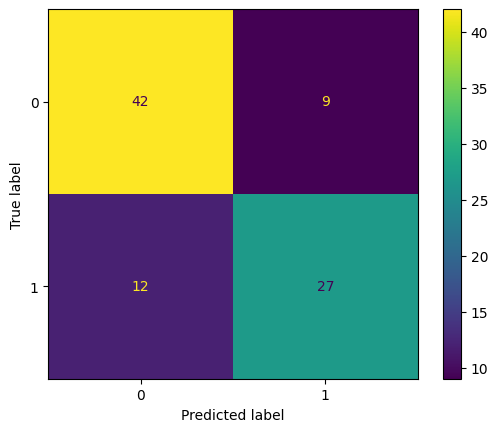

              precision    recall  f1-score   support

 no_conflict       0.78      0.82      0.80        51
    conflict       0.75      0.69      0.72        39

    accuracy                           0.77        90
   macro avg       0.76      0.76      0.76        90
weighted avg       0.77      0.77      0.77        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.76667
conflict_f1-score,0.72
conflict_precision,0.75
conflict_recall,0.69231


  0%|          | 0/90 [00:00<?, ?it/s]

[[26 25]
 [ 7 32]]


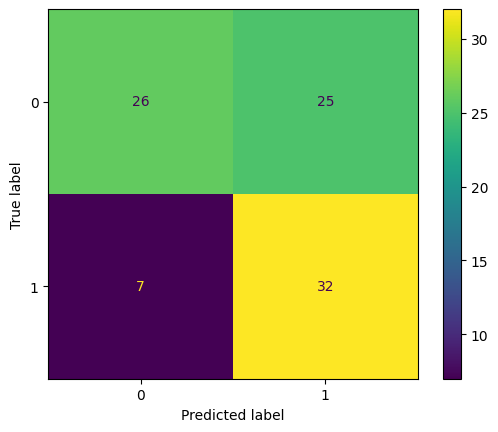

              precision    recall  f1-score   support

 no_conflict       0.79      0.51      0.62        51
    conflict       0.56      0.82      0.67        39

    accuracy                           0.64        90
   macro avg       0.67      0.67      0.64        90
weighted avg       0.69      0.64      0.64        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.64444
conflict_f1-score,0.66667
conflict_precision,0.5614
conflict_recall,0.82051


  0%|          | 0/90 [00:00<?, ?it/s]

[[29 22]
 [16 23]]


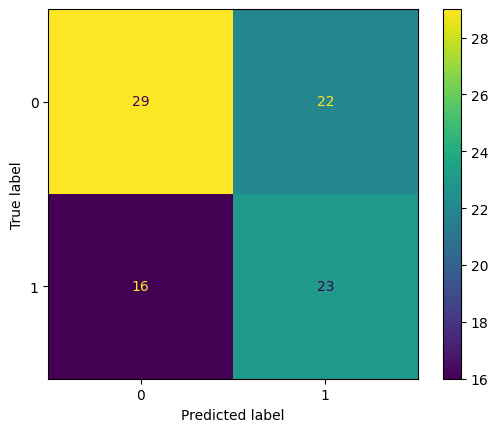

              precision    recall  f1-score   support

 no_conflict       0.64      0.57      0.60        51
    conflict       0.51      0.59      0.55        39

    accuracy                           0.58        90
   macro avg       0.58      0.58      0.58        90
weighted avg       0.59      0.58      0.58        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.57778
conflict_f1-score,0.54762
conflict_precision,0.51111
conflict_recall,0.58974


  0%|          | 0/90 [00:00<?, ?it/s]

[[ 8 43]
 [ 2 37]]


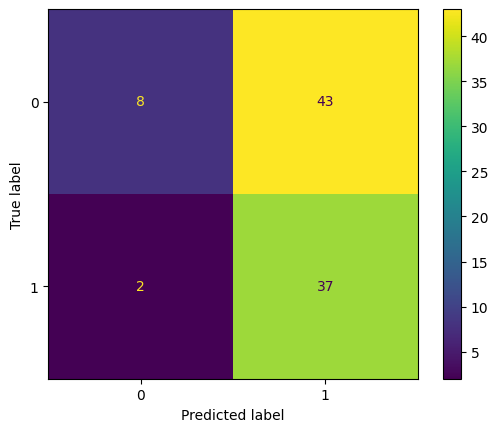

              precision    recall  f1-score   support

 no_conflict       0.80      0.16      0.26        51
    conflict       0.46      0.95      0.62        39

    accuracy                           0.50        90
   macro avg       0.63      0.55      0.44        90
weighted avg       0.65      0.50      0.42        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.5
conflict_f1-score,0.62185
conflict_precision,0.4625
conflict_recall,0.94872


  0%|          | 0/90 [00:00<?, ?it/s]

[[46  5]
 [12 27]]


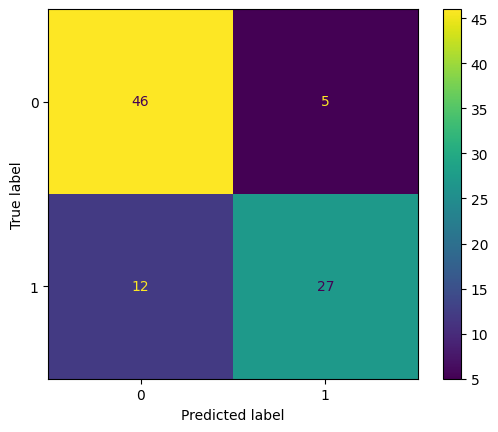

              precision    recall  f1-score   support

 no_conflict       0.79      0.90      0.84        51
    conflict       0.84      0.69      0.76        39

    accuracy                           0.81        90
   macro avg       0.82      0.80      0.80        90
weighted avg       0.82      0.81      0.81        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.81111
conflict_f1-score,0.76056
conflict_precision,0.84375
conflict_recall,0.69231


  0%|          | 0/90 [00:00<?, ?it/s]

[[50  1]
 [33  6]]


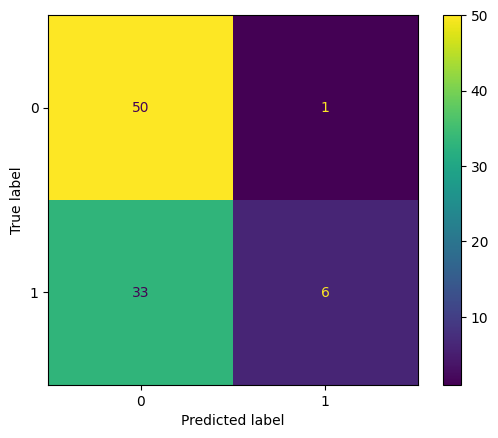

              precision    recall  f1-score   support

 no_conflict       0.60      0.98      0.75        51
    conflict       0.86      0.15      0.26        39

    accuracy                           0.62        90
   macro avg       0.73      0.57      0.50        90
weighted avg       0.71      0.62      0.54        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.62222
conflict_f1-score,0.26087
conflict_precision,0.85714
conflict_recall,0.15385


  0%|          | 0/90 [00:00<?, ?it/s]

[[47  4]
 [23 16]]


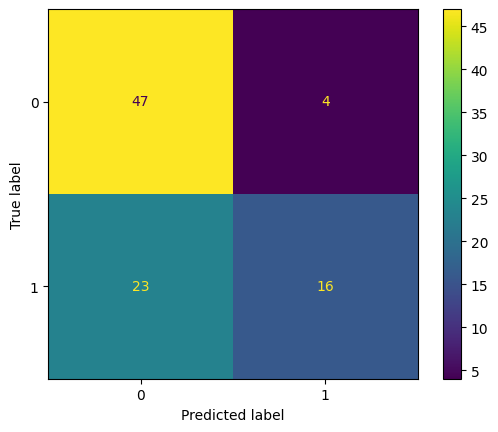

              precision    recall  f1-score   support

 no_conflict       0.67      0.92      0.78        51
    conflict       0.80      0.41      0.54        39

    accuracy                           0.70        90
   macro avg       0.74      0.67      0.66        90
weighted avg       0.73      0.70      0.68        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.7
conflict_f1-score,0.54237
conflict_precision,0.8
conflict_recall,0.41026


  0%|          | 0/90 [00:00<?, ?it/s]

[[46  5]
 [16 23]]


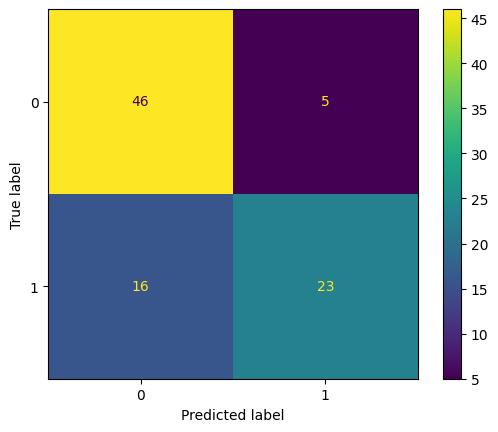

              precision    recall  f1-score   support

 no_conflict       0.74      0.90      0.81        51
    conflict       0.82      0.59      0.69        39

    accuracy                           0.77        90
   macro avg       0.78      0.75      0.75        90
weighted avg       0.78      0.77      0.76        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.76667
conflict_f1-score,0.68657
conflict_precision,0.82143
conflict_recall,0.58974


  0%|          | 0/90 [00:00<?, ?it/s]

[[38 13]
 [10 29]]


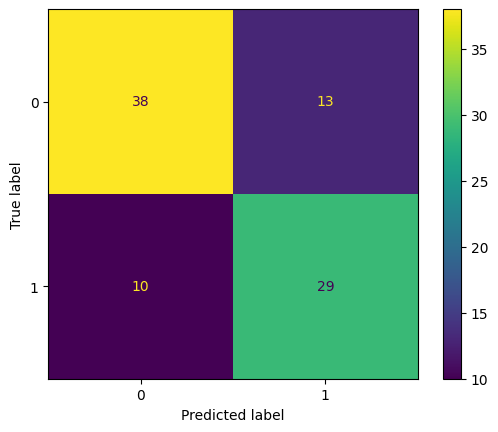

              precision    recall  f1-score   support

 no_conflict       0.79      0.75      0.77        51
    conflict       0.69      0.74      0.72        39

    accuracy                           0.74        90
   macro avg       0.74      0.74      0.74        90
weighted avg       0.75      0.74      0.75        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.74444
conflict_f1-score,0.71605
conflict_precision,0.69048
conflict_recall,0.74359


  0%|          | 0/90 [00:00<?, ?it/s]

[[50  1]
 [17 22]]


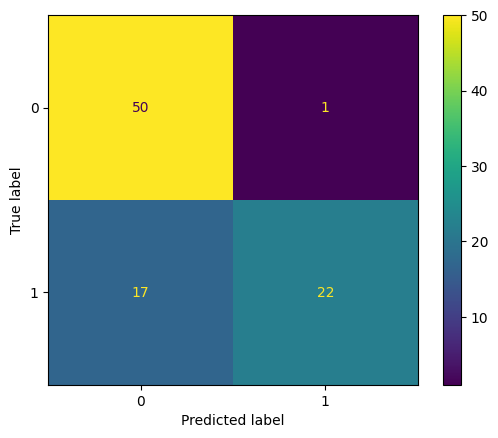

              precision    recall  f1-score   support

 no_conflict       0.75      0.98      0.85        51
    conflict       0.96      0.56      0.71        39

    accuracy                           0.80        90
   macro avg       0.85      0.77      0.78        90
weighted avg       0.84      0.80      0.79        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.8
conflict_f1-score,0.70968
conflict_precision,0.95652
conflict_recall,0.5641


  0%|          | 0/90 [00:00<?, ?it/s]

[[50  1]
 [30  9]]


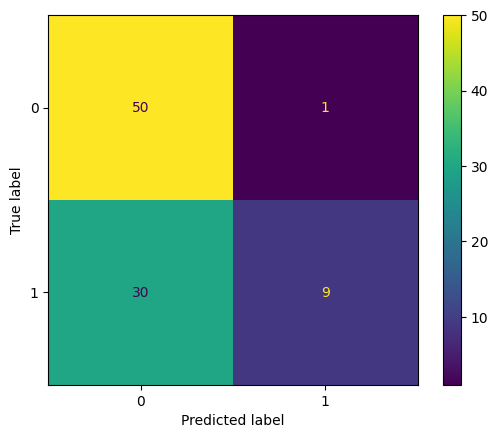

              precision    recall  f1-score   support

 no_conflict       0.62      0.98      0.76        51
    conflict       0.90      0.23      0.37        39

    accuracy                           0.66        90
   macro avg       0.76      0.61      0.57        90
weighted avg       0.74      0.66      0.59        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.65556
conflict_f1-score,0.36735
conflict_precision,0.9
conflict_recall,0.23077


  0%|          | 0/90 [00:00<?, ?it/s]

[[44  7]
 [15 24]]


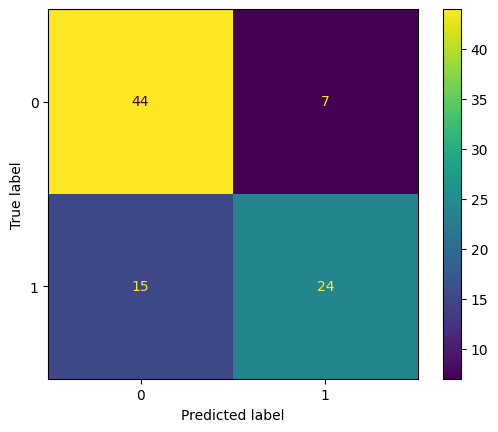

              precision    recall  f1-score   support

 no_conflict       0.75      0.86      0.80        51
    conflict       0.77      0.62      0.69        39

    accuracy                           0.76        90
   macro avg       0.76      0.74      0.74        90
weighted avg       0.76      0.76      0.75        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.75556
conflict_f1-score,0.68571
conflict_precision,0.77419
conflict_recall,0.61538


  0%|          | 0/90 [00:00<?, ?it/s]

[[27 24]
 [ 7 32]]


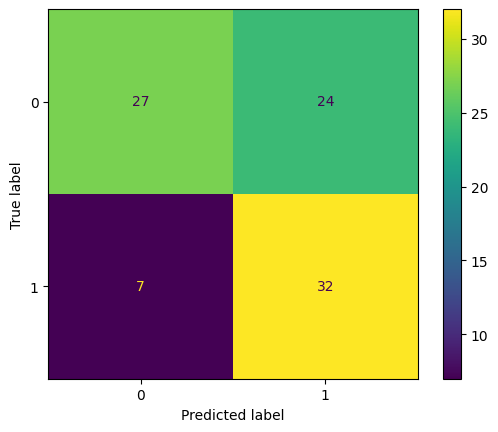

              precision    recall  f1-score   support

 no_conflict       0.79      0.53      0.64        51
    conflict       0.57      0.82      0.67        39

    accuracy                           0.66        90
   macro avg       0.68      0.67      0.65        90
weighted avg       0.70      0.66      0.65        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.65556
conflict_f1-score,0.67368
conflict_precision,0.57143
conflict_recall,0.82051


  0%|          | 0/90 [00:00<?, ?it/s]

[[33 18]
 [13 26]]


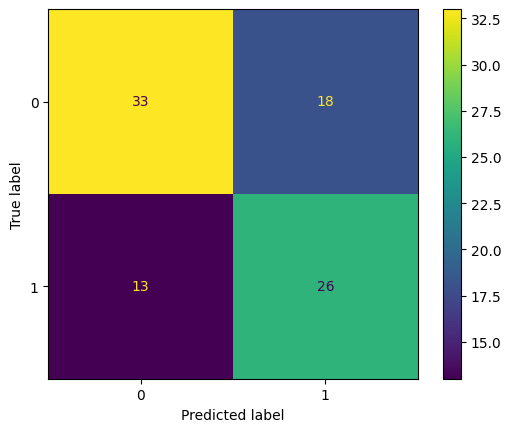

              precision    recall  f1-score   support

 no_conflict       0.72      0.65      0.68        51
    conflict       0.59      0.67      0.63        39

    accuracy                           0.66        90
   macro avg       0.65      0.66      0.65        90
weighted avg       0.66      0.66      0.66        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.65556
conflict_f1-score,0.62651
conflict_precision,0.59091
conflict_recall,0.66667


  0%|          | 0/90 [00:00<?, ?it/s]

[[12 39]
 [ 4 35]]


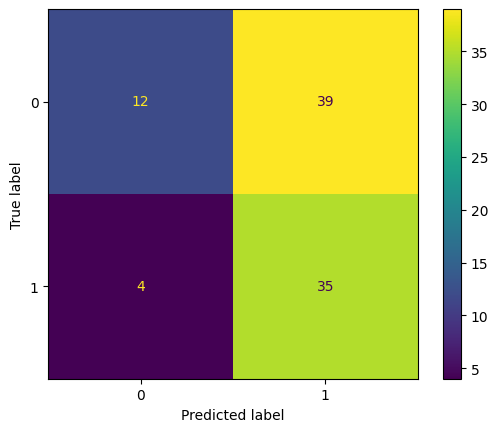

              precision    recall  f1-score   support

 no_conflict       0.75      0.24      0.36        51
    conflict       0.47      0.90      0.62        39

    accuracy                           0.52        90
   macro avg       0.61      0.57      0.49        90
weighted avg       0.63      0.52      0.47        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.52222
conflict_f1-score,0.61947
conflict_precision,0.47297
conflict_recall,0.89744


  0%|          | 0/90 [00:00<?, ?it/s]

[[43  8]
 [14 25]]


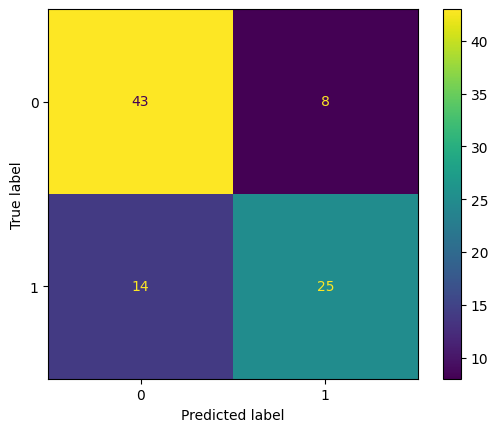

              precision    recall  f1-score   support

 no_conflict       0.75      0.84      0.80        51
    conflict       0.76      0.64      0.69        39

    accuracy                           0.76        90
   macro avg       0.76      0.74      0.75        90
weighted avg       0.76      0.76      0.75        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.75556
conflict_f1-score,0.69444
conflict_precision,0.75758
conflict_recall,0.64103


  0%|          | 0/90 [00:00<?, ?it/s]

[[49  2]
 [34  5]]


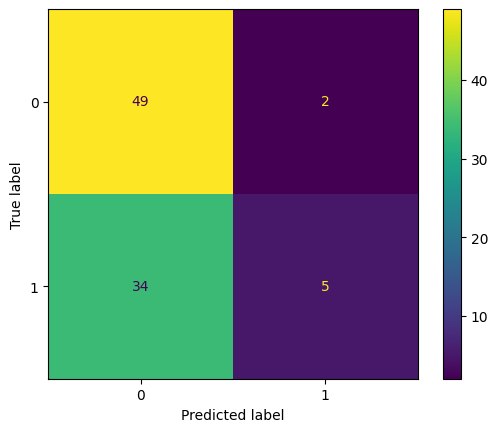

              precision    recall  f1-score   support

 no_conflict       0.59      0.96      0.73        51
    conflict       0.71      0.13      0.22        39

    accuracy                           0.60        90
   macro avg       0.65      0.54      0.47        90
weighted avg       0.64      0.60      0.51        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.6
conflict_f1-score,0.21739
conflict_precision,0.71429
conflict_recall,0.12821


  0%|          | 0/90 [00:00<?, ?it/s]

[[49  2]
 [20 19]]


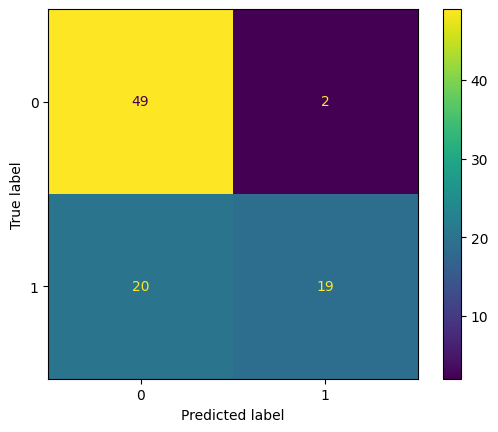

              precision    recall  f1-score   support

 no_conflict       0.71      0.96      0.82        51
    conflict       0.90      0.49      0.63        39

    accuracy                           0.76        90
   macro avg       0.81      0.72      0.72        90
weighted avg       0.79      0.76      0.74        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.75556
conflict_f1-score,0.63333
conflict_precision,0.90476
conflict_recall,0.48718


In [ ]:
labels = [(["позитив", "негатив"], ['негатив']),
          (["positive", "negative"], ['negative']),
          (["позитив", "негатив", "нейтральне"], ['негатив']),
          (["позитив", "негатив", "неитральное"], ['негатив']),
          (["positive", "negative", "neutral"], ['negative']),
          (["конфлікт", "нейтральне"], ['конфлікт']),
          (["конфликт", "неитральное"], ['конфликт']),
          (["conflict", "neutral"], ['conflict']),
          (["щастя","нейтральне","злість"], ['злість']),
          (["счастье","неитральное","злость"], ['злость']),
          (["happy", "angry", "neutral"], ['angry'])]

text_columns = ['origin_text', 'openai/whisper-large-v2_transc']
negative_lables = ["негатив"] # need to correctly transform output
lang="uk_ru"
models = ["MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"]

for text_column in text_columns:
  for text_labels, negative_lables in labels:
    eval_class_model(models[0], text_labels, labels_lang=lang, df=df_meta,
                    text_column=text_column, class_column="conflict_sad",
                    conflict_labels=negative_lables)

  0%|          | 0/90 [00:00<?, ?it/s]

[[41 10]
 [22 17]]


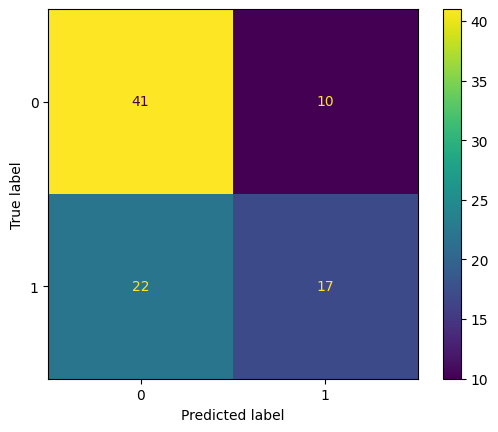

              precision    recall  f1-score   support

 no_conflict       0.65      0.80      0.72        51
    conflict       0.63      0.44      0.52        39

    accuracy                           0.64        90
   macro avg       0.64      0.62      0.62        90
weighted avg       0.64      0.64      0.63        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.64444
conflict_f1-score,0.51515
conflict_precision,0.62963
conflict_recall,0.4359


In [ ]:
labels = ["позитив", "неитральное", "конфликт"]
negative_lables = ["конфликт"] # need to correctly transform output
lang="ru"
text_column="origin_text"
models = ["MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"]

eval_class_model(models[0], labels, labels_lang=lang, df=df_meta,
                 text_column=text_column, class_column="conflict_sad",
                 conflict_labels=negative_lables)

  0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


[[50  1]
 [17 22]]


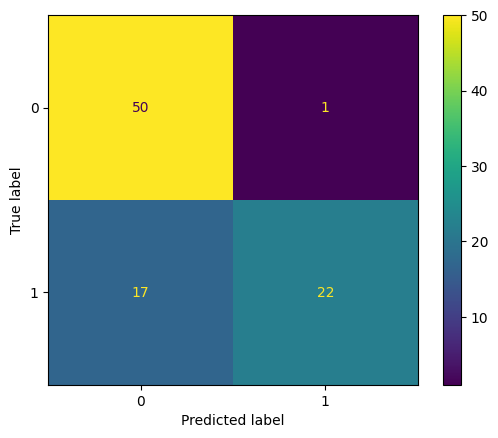

              precision    recall  f1-score   support

 no_conflict       0.75      0.98      0.85        51
    conflict       0.96      0.56      0.71        39

    accuracy                           0.80        90
   macro avg       0.85      0.77      0.78        90
weighted avg       0.84      0.80      0.79        90



In [ ]:
labels = ["позитив", "нейтральне", "негатив"]
negative_lables = ["негатив"] # need to correctly transform output
origin_colums = [#'origin_text',
                 "openai/whisper-large-v2_transc",
                 #"openai/whisper-large-v3_transc"
                 ]
models = ["MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
          "MoritzLaurer/deberta-v3-base-zeroshot-v1.1-all-33"]

for column in origin_colums:
  eval_class_model(models[0], labels, labels_lang="uk_ru", df=df_meta,
                  text_column=column, class_column="conflict_sad",
                  conflict_labels=negative_lables, log=False, saveTo="uk_ru_whisperv2_base_xnil_binary")

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/870M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

  0%|          | 0/90 [00:00<?, ?it/s]

[[51  0]
 [30  9]]


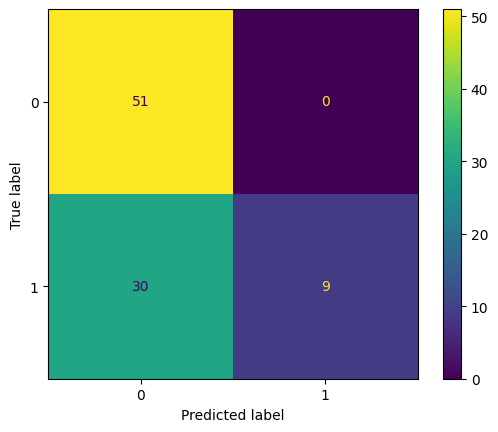

              precision    recall  f1-score   support

 no_conflict       0.63      1.00      0.77        51
    conflict       1.00      0.23      0.38        39

    accuracy                           0.67        90
   macro avg       0.81      0.62      0.57        90
weighted avg       0.79      0.67      0.60        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.66667
conflict_f1-score,0.375
conflict_precision,1.0
conflict_recall,0.23077


  0%|          | 0/90 [00:00<?, ?it/s]

[[47  4]
 [20 19]]


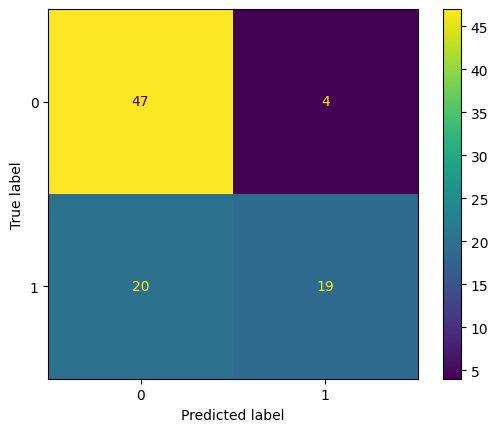

              precision    recall  f1-score   support

 no_conflict       0.70      0.92      0.80        51
    conflict       0.83      0.49      0.61        39

    accuracy                           0.73        90
   macro avg       0.76      0.70      0.70        90
weighted avg       0.76      0.73      0.72        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.73333
conflict_f1-score,0.6129
conflict_precision,0.82609
conflict_recall,0.48718


  0%|          | 0/90 [00:00<?, ?it/s]

[[47  4]
 [24 15]]


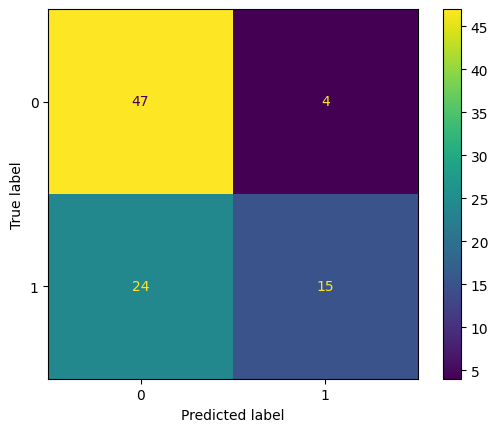

              precision    recall  f1-score   support

 no_conflict       0.66      0.92      0.77        51
    conflict       0.79      0.38      0.52        39

    accuracy                           0.69        90
   macro avg       0.73      0.65      0.64        90
weighted avg       0.72      0.69      0.66        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.68889
conflict_f1-score,0.51724
conflict_precision,0.78947
conflict_recall,0.38462


  0%|          | 0/90 [00:00<?, ?it/s]

[[48  3]
 [21 18]]


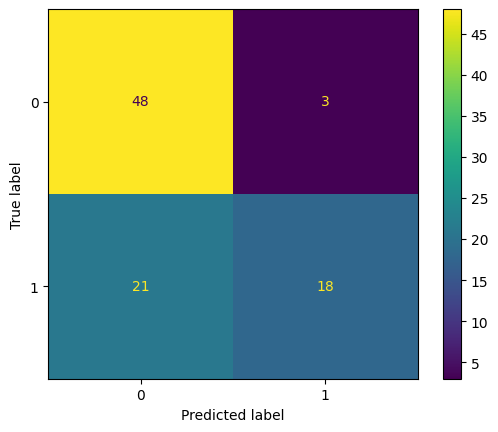

              precision    recall  f1-score   support

 no_conflict       0.70      0.94      0.80        51
    conflict       0.86      0.46      0.60        39

    accuracy                           0.73        90
   macro avg       0.78      0.70      0.70        90
weighted avg       0.77      0.73      0.71        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.73333
conflict_f1-score,0.6
conflict_precision,0.85714
conflict_recall,0.46154


In [ ]:
labels = ["positive", "negative", "neutral"]
negative_lables = ["negative"] # need to correctly transform output
models = ["MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
          "MoritzLaurer/deberta-v3-base-zeroshot-v1.1-all-33",
          "MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33"]

origin_colums = ['origin_text',
                    'openai/whisper-medium_translate',
                    'openai/whisper-large-v2_translate',
                    'openai/whisper-large-v3_translate']

for column in origin_colums:
  eval_class_model(models[2], labels, labels_lang="en", df=df_meta,
                  text_column=column, class_column="conflict_sad",
                  conflict_labels=negative_lables)

  0%|          | 0/90 [00:00<?, ?it/s]

[[51  0]
 [36  3]]


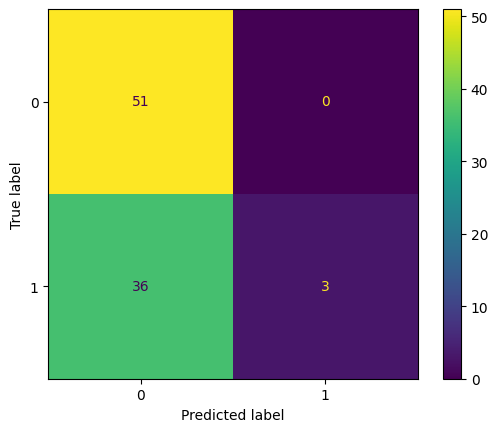

              precision    recall  f1-score   support

 no_conflict       0.59      1.00      0.74        51
    conflict       1.00      0.08      0.14        39

    accuracy                           0.60        90
   macro avg       0.79      0.54      0.44        90
weighted avg       0.77      0.60      0.48        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.6
conflict_f1-score,0.14286
conflict_precision,1.0
conflict_recall,0.07692


  0%|          | 0/90 [00:00<?, ?it/s]

[[51  0]
 [32  7]]


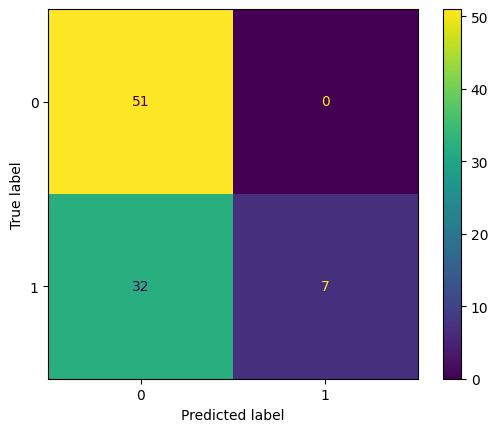

              precision    recall  f1-score   support

 no_conflict       0.61      1.00      0.76        51
    conflict       1.00      0.18      0.30        39

    accuracy                           0.64        90
   macro avg       0.81      0.59      0.53        90
weighted avg       0.78      0.64      0.56        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.64444
conflict_f1-score,0.30435
conflict_precision,1.0
conflict_recall,0.17949


  0%|          | 0/90 [00:00<?, ?it/s]

[[51  0]
 [34  5]]


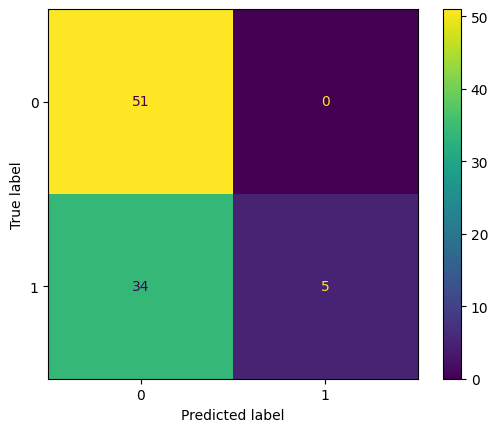

              precision    recall  f1-score   support

 no_conflict       0.60      1.00      0.75        51
    conflict       1.00      0.13      0.23        39

    accuracy                           0.62        90
   macro avg       0.80      0.56      0.49        90
weighted avg       0.77      0.62      0.52        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.62222
conflict_f1-score,0.22727
conflict_precision,1.0
conflict_recall,0.12821


  0%|          | 0/90 [00:00<?, ?it/s]

[[51  0]
 [35  4]]


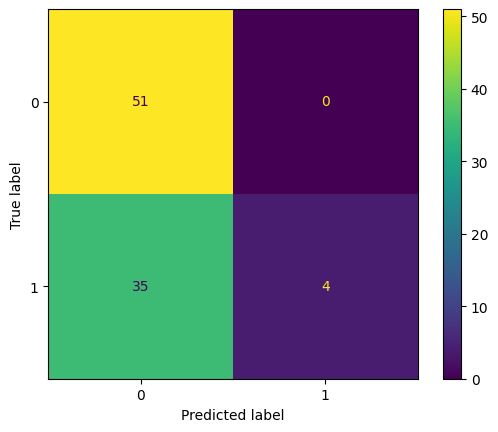

              precision    recall  f1-score   support

 no_conflict       0.59      1.00      0.74        51
    conflict       1.00      0.10      0.19        39

    accuracy                           0.61        90
   macro avg       0.80      0.55      0.47        90
weighted avg       0.77      0.61      0.50        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.61111
conflict_f1-score,0.18605
conflict_precision,1.0
conflict_recall,0.10256


In [ ]:
labels = ["happiness", "neutral", "angry"]
negative_lables = ["angry"] # need to correctly transform output
models = ["MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
          "MoritzLaurer/deberta-v3-base-zeroshot-v1.1-all-33",
          "MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33"]

origin_colums = ['origin_text',
                    'openai/whisper-medium_translate',
                    'openai/whisper-large-v2_translate',
                    'openai/whisper-large-v3_translate']

for column in origin_colums:
  eval_class_model(models[2], labels, labels_lang="en", df=df_meta,
                  text_column=column, class_column="conflict_sad",
                  conflict_labels=negative_lables)

## Sentiment classifier

  0%|          | 0/90 [00:00<?, ?it/s]

[[12 39]
 [ 0 39]]


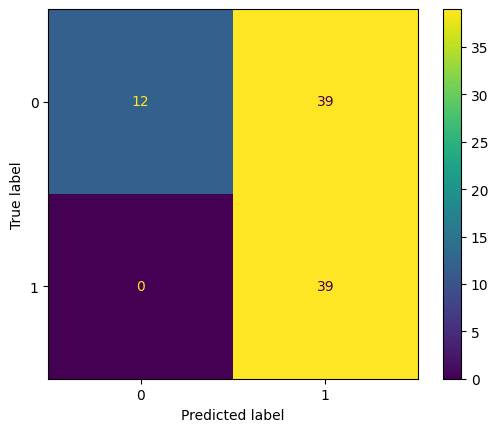

              precision    recall  f1-score   support

 no_conflict       1.00      0.24      0.38        51
    conflict       0.50      1.00      0.67        39

    accuracy                           0.57        90
   macro avg       0.75      0.62      0.52        90
weighted avg       0.78      0.57      0.50        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.56667
conflict_f1-score,0.66667
conflict_precision,0.5
conflict_recall,1.0


  0%|          | 0/90 [00:00<?, ?it/s]

[[29 22]
 [ 5 34]]


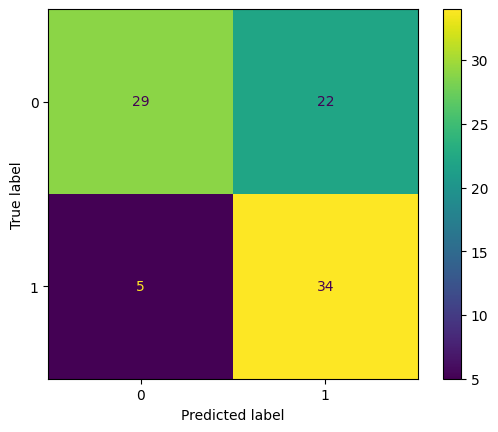

              precision    recall  f1-score   support

 no_conflict       0.85      0.57      0.68        51
    conflict       0.61      0.87      0.72        39

    accuracy                           0.70        90
   macro avg       0.73      0.72      0.70        90
weighted avg       0.75      0.70      0.70        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.7
conflict_f1-score,0.71579
conflict_precision,0.60714
conflict_recall,0.87179


  0%|          | 0/90 [00:00<?, ?it/s]

[[32 19]
 [ 6 33]]


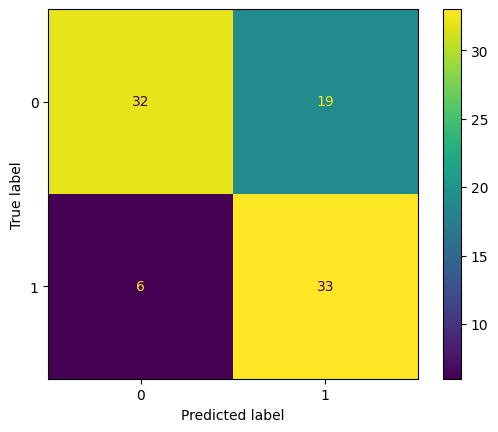

              precision    recall  f1-score   support

 no_conflict       0.84      0.63      0.72        51
    conflict       0.63      0.85      0.73        39

    accuracy                           0.72        90
   macro avg       0.74      0.74      0.72        90
weighted avg       0.75      0.72      0.72        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.72222
conflict_f1-score,0.72527
conflict_precision,0.63462
conflict_recall,0.84615


  0%|          | 0/90 [00:00<?, ?it/s]

[[28 23]
 [ 6 33]]


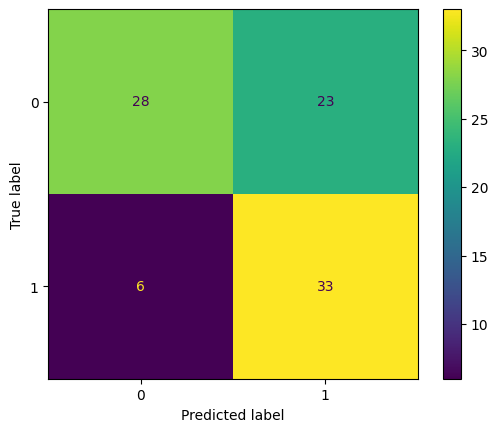

              precision    recall  f1-score   support

 no_conflict       0.82      0.55      0.66        51
    conflict       0.59      0.85      0.69        39

    accuracy                           0.68        90
   macro avg       0.71      0.70      0.68        90
weighted avg       0.72      0.68      0.67        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.67778
conflict_f1-score,0.69474
conflict_precision,0.58929
conflict_recall,0.84615


In [ ]:
labels = None
negative_lables = ["negative"] # need to correctly transform output
lang="eng"
models = ["lxyuan/distilbert-base-multilingual-cased-sentiments-student"]

origin_colums = ['origin_text',
                    'openai/whisper-medium_translate',
                    'openai/whisper-large-v2_translate',
                    'openai/whisper-large-v3_translate']

for column in origin_colums:
  eval_class_model(models[0], labels, labels_lang="en", df=df_meta,
                  text_column=column, class_column="conflict_sad",
                  conflict_labels=negative_lables)

In [ ]:
test = get_classifier(models[0])
test("aaaa")

[{'label': 'POSITIVE', 'score': 0.99603670835495}]

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

  0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


[[46  5]
 [ 9 30]]


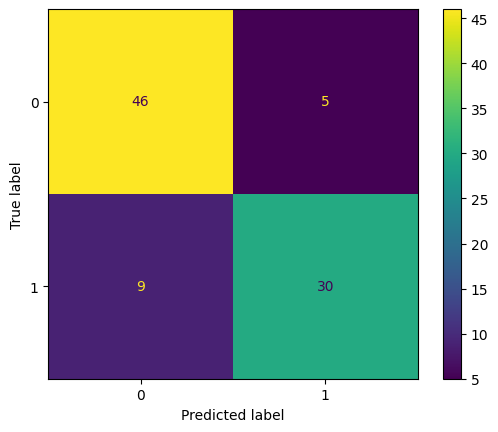

              precision    recall  f1-score   support

 no_conflict       0.84      0.90      0.87        51
    conflict       0.86      0.77      0.81        39

    accuracy                           0.84        90
   macro avg       0.85      0.84      0.84        90
weighted avg       0.85      0.84      0.84        90



NameError: name 'wandb' is not defined

In [ ]:
labels = None
negative_lables = ["negative"] # need to correctly transform output
lang="eng"
models = ["siebert/sentiment-roberta-large-english",
          "cardiffnlp/twitter-roberta-base-sentiment-latest"]

origin_colums = [#'openai/whisper-medium_translate',
                    'openai/whisper-large-v2_translate',
                    #'openai/whisper-large-v3_translate'
                    ]

for column in origin_colums:
  eval_class_model(models[1], labels, labels_lang="en", df=df_meta,
                  text_column=column, class_column="conflict_sad",
                  conflict_labels=negative_lables, log=False, saveTo="eng_cardiffnlp_res")

## Emotion classification

  0%|          | 0/90 [00:00<?, ?it/s]

['confusion' 'disapproval' 'confusion' 'disapproval' 'approval'
 'gratitude' 'desire' 'annoyance' 'approval' 'approval' 'approval'
 'realization' 'remorse' 'disapproval' 'curiosity' 'confusion' 'sadness'
 'gratitude' 'gratitude' 'approval' 'confusion' 'disappointment'
 'gratitude' 'confusion' 'confusion' 'annoyance' 'anger' 'joy' 'approval'
 'remorse' 'gratitude' 'approval' 'disapproval' 'gratitude' 'gratitude'
 'confusion' 'approval' 'curiosity' 'fear' 'remorse' 'approval'
 'disappointment' 'approval' 'gratitude' 'annoyance' 'gratitude'
 'confusion' 'approval' 'approval' 'disapproval' 'gratitude' 'confusion'
 'disappointment' 'approval' 'disapproval' 'gratitude' 'confusion'
 'approval' 'confusion' 'confusion' 'curiosity' 'gratitude' 'annoyance'
 'excitement' 'confusion' 'annoyance' 'remorse' 'gratitude' 'confusion'
 'disapproval' 'annoyance' 'gratitude' 'annoyance' 'confusion'
 'disappointment' 'gratitude' 'confusion' 'curiosity' 'approval'
 'gratitude' 'gratitude' 'desire' 'curiosity

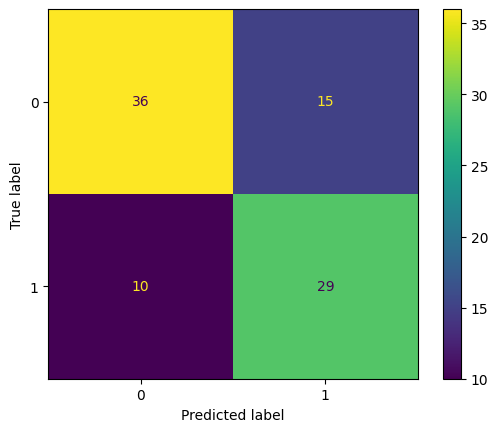

              precision    recall  f1-score   support

 no_conflict       0.78      0.71      0.74        51
    conflict       0.66      0.74      0.70        39

    accuracy                           0.72        90
   macro avg       0.72      0.72      0.72        90
weighted avg       0.73      0.72      0.72        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.72222
conflict_f1-score,0.6988
conflict_precision,0.65909
conflict_recall,0.74359


In [ ]:
labels = None
negative_lables = ['disappointment',
                    'sadness',
                    'annoyance',
                    'disapproval',
                    'nervousness',
                    'remorse',
                    'embarrassment',
                    'anger',
                    'disgust',
                    'grief',
                    'confusion',
                    'fear'
                  ] # need to correctly transform output
lang="eng"
models = ["SamLowe/roberta-base-go_emotions"]

origin_colums = [#'openai/whisper-medium_translate',
                    'openai/whisper-large-v2_translate',
                    #'openai/whisper-large-v3_translate'
                    ]

for column in origin_colums:
  eval_class_model(models[0], labels, labels_lang="en", df=df_meta,
                  text_column=column, class_column="conflict_sad",
                  conflict_labels=negative_lables)

In [ ]:
[x for x in test if not ('neutral' == x.get('label'))]



[{'label': 'disappointment', 'score': 0.46669524908065796},
 {'label': 'sadness', 'score': 0.398495078086853},
 {'label': 'annoyance', 'score': 0.06806596368551254},
 {'label': 'disapproval', 'score': 0.04423932731151581},
 {'label': 'nervousness', 'score': 0.014850745908915997},
 {'label': 'realization', 'score': 0.014059904962778091},
 {'label': 'approval', 'score': 0.011267471127212048},
 {'label': 'joy', 'score': 0.006303394213318825},
 {'label': 'remorse', 'score': 0.006221492309123278},
 {'label': 'caring', 'score': 0.006029406096786261},
 {'label': 'embarrassment', 'score': 0.0052654859609901905},
 {'label': 'anger', 'score': 0.0049814279191195965},
 {'label': 'disgust', 'score': 0.004259033594280481},
 {'label': 'grief', 'score': 0.0040021371096372604},
 {'label': 'confusion', 'score': 0.003382918192073703},
 {'label': 'relief', 'score': 0.0031405005138367414},
 {'label': 'desire', 'score': 0.00282747158780694},
 {'label': 'admiration', 'score': 0.002815794898197055},
 {'label'

In [ ]:
df_stats = df_meta[['speech_duration', 'language', 'conflict_sad', 'eng_cardiffnlp_res', 'uk_ru_origin_base_xnil_binary',
       'uk_ru_whisperv2_base_xnil_binary']]

In [ ]:
def calc_accuracy(lang, binary_res_col):
  accuracy = np.sum(df_stats[df_stats['language'] == lang]['conflict_sad'] == df_stats[df_stats['language'] == lang][binary_res_col])/len(df_stats[df_stats['language'] == lang][binary_res_col])
  print(f"for langauge {lang} and column {binary_res_col} accuracy is {round(accuracy,2)*100}%")

## Accuracy per language

In [ ]:
calc_accuracy('ru', 'eng_cardiffnlp_res')
calc_accuracy('uk', 'eng_cardiffnlp_res')

for langauge ru and column eng_cardiffnlp_res accuracy is 86.0%
for langauge uk and column eng_cardiffnlp_res accuracy is 80.0%


In [ ]:
calc_accuracy('ru', 'uk_ru_origin_base_xnil_binary')
calc_accuracy('uk', 'uk_ru_origin_base_xnil_binary')

for langauge ru and column uk_ru_origin_base_xnil_binary accuracy is 79.0%
for langauge uk and column uk_ru_origin_base_xnil_binary accuracy is 80.0%


In [ ]:
calc_accuracy('ru', 'uk_ru_whisperv2_base_xnil_binary')
calc_accuracy('uk', 'uk_ru_whisperv2_base_xnil_binary')

for langauge ru and column uk_ru_whisperv2_base_xnil_binary accuracy is 77.0%
for langauge uk and column uk_ru_whisperv2_base_xnil_binary accuracy is 90.0%


In [ ]:
df_stats.groupby(by='language').sum()

,speech_duration,conflict_sad,eng_cardiffnlp_res,uk_ru_origin_base_xnil_binary,uk_ru_whisperv2_base_xnil_binary
language,,,,,
ru,3515.707404,30,26,19,16
uk,1031.863769,9,9,9,7


In [ ]:
def calc_accuracy_2(lang, binary_res_col, binary_conflict):
  accuracy = np.sum(df_stats[(df_stats['language'] == lang) & (df_stats['conflict_sad'] == binary_conflict)]['conflict_sad'] == df_stats[(df_stats['language'] == lang) & (df_stats['conflict_sad'] == binary_conflict)][binary_res_col])/len(df_stats[(df_stats['language'] == lang) & (df_stats['conflict_sad'] == binary_conflict)][binary_res_col])
  print(f"for langauge {lang} and column {binary_res_col} accuracy is {round(accuracy,2)*100}%")

In [ ]:
bin_conflict = 0

calc_accuracy_2('ru', 'eng_cardiffnlp_res', bin_conflict)
calc_accuracy_2('uk', 'eng_cardiffnlp_res', bin_conflict)
calc_accuracy_2('ru', 'uk_ru_origin_base_xnil_binary', bin_conflict)
calc_accuracy_2('uk', 'uk_ru_origin_base_xnil_binary', bin_conflict)
calc_accuracy_2('ru', 'uk_ru_whisperv2_base_xnil_binary', bin_conflict)
calc_accuracy_2('uk', 'uk_ru_whisperv2_base_xnil_binary', bin_conflict)

for langauge ru and column eng_cardiffnlp_res accuracy is 92.0%
for langauge uk and column eng_cardiffnlp_res accuracy is 82.0%
for langauge ru and column uk_ru_origin_base_xnil_binary accuracy is 95.0%
for langauge uk and column uk_ru_origin_base_xnil_binary accuracy is 82.0%
for langauge ru and column uk_ru_whisperv2_base_xnil_binary accuracy is 98.0%
for langauge uk and column uk_ru_whisperv2_base_xnil_binary accuracy is 100.0%


In [ ]:
bin_conflict = 1

calc_accuracy_2('ru', 'eng_cardiffnlp_res', bin_conflict)
calc_accuracy_2('uk', 'eng_cardiffnlp_res', bin_conflict)
calc_accuracy_2('ru', 'uk_ru_origin_base_xnil_binary', bin_conflict)
calc_accuracy_2('uk', 'uk_ru_origin_base_xnil_binary', bin_conflict)
calc_accuracy_2('ru', 'uk_ru_whisperv2_base_xnil_binary', bin_conflict)
calc_accuracy_2('uk', 'uk_ru_whisperv2_base_xnil_binary', bin_conflict)

for langauge ru and column eng_cardiffnlp_res accuracy is 77.0%
for langauge uk and column eng_cardiffnlp_res accuracy is 78.0%
for langauge ru and column uk_ru_origin_base_xnil_binary accuracy is 56.99999999999999%
for langauge uk and column uk_ru_origin_base_xnil_binary accuracy is 78.0%
for langauge ru and column uk_ru_whisperv2_base_xnil_binary accuracy is 50.0%
for langauge uk and column uk_ru_whisperv2_base_xnil_binary accuracy is 78.0%


# LLM instruction test

In [ ]:
import os
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [ ]:
import torch

In [ ]:
!pip install accelerate

In [1]:
import accelerate
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b-it")
model = AutoModelForCausalLM.from_pretrained("google/gemma-7b-it", device_map={"":0})

In [2]:
conversation = '...'
prompt = 'analyze the following text and decide if there is a conflict in this text: ' + conversation


input_ids = tokenizer(prompt, return_tensors="pt")

outputs = model.generate(**input_ids, max_new_tokens=250)
print(tokenizer.decode(outputs[0]))

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

In [ ]:
def predict_llm(text):
  prompt = f"""
  Analyze the following text (transcribed from the call center conversation) and decide if there is a conflict or miscommunication in this text. Provide 1 word as an answer (conflict or neutral):
  Text: {text}
  """

  messages = [
    {"role": "user", "content": prompt},
  ]

  encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

  model_inputs = encodeds.to(device)
  model.to(device)

  generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True)
  decoded = tokenizer.batch_decode(generated_ids)

  return decoded[0]

In [3]:
input_column = 'openai/whisper-large-v2_translate'
df_meta['mixtral_7b_full'] = df_meta[input_column].progress_apply(predict_llm)


In [ ]:
import re
df_meta['mixtral_7b_class'] = df_meta['mixtral_7b_full'].progress_apply(lambda x: x.split('[/INST]')[1])
df_meta['mixtral_7b_class'] = df_meta['mixtral_7b_class'].progress_apply(lambda x: re.split('\W+', x)[1].strip())
df_meta['mixtral_7b_class'] = df_meta['mixtral_7b_class'].progress_apply(lambda x: 1 if x.lower() == "conflict" else 0)



  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

[[48  3]
 [18 21]]


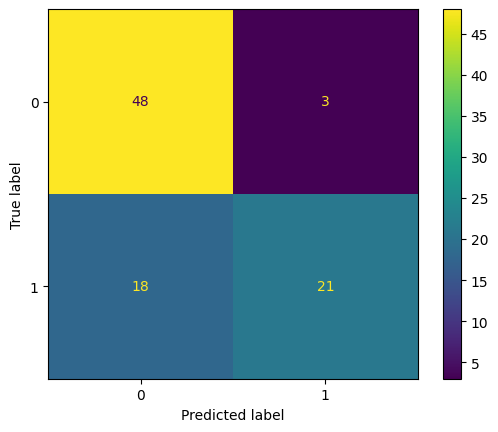

              precision    recall  f1-score   support

 no_conflict       0.73      0.94      0.82        51
    conflict       0.88      0.54      0.67        39

    accuracy                           0.77        90
   macro avg       0.80      0.74      0.74        90
weighted avg       0.79      0.77      0.75        90



In [ ]:
#def evaluate(y_true, y_pred, run, display_cm=True, display_cr=True):
evaluate(df_meta['conflict_sad'], df_meta['mixtral_7b_class'], None)